<a href="https://colab.research.google.com/github/LigiaKaczmarek/Uczenie-Maszynowe-w-finansach/blob/main/Zadanie_2_LK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
!pip install scikit-surprise


1. Przegląd danych:

In [35]:
ratings = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv')
movies = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv')
movies[8210:8300]

,movieId,title,genres
8210,103543,"Lifeguard, The (2013)",Comedy|Drama
8211,103596,Sharknado (2013),Sci-Fi
8212,103602,Craig Ferguson: I'm Here To Help (2013),Comedy|Documentary
8213,103606,Stuck in Love (2012),Comedy|Drama|Romance
8214,103609,Class Act (1992),Comedy
...,...,...,...
8295,106487,The Hunger Games: Catching Fire (2013),Action|Adventure|Sci-Fi|IMAX
8296,106489,"Hobbit: The Desolation of Smaug, The (2013)",Adventure|Fantasy|IMAX
8297,106491,47 Ronin (2013),Action|Adventure|Fantasy
8298,106540,Delivery Man (2013),Comedy


In [36]:
movie_ratings = ratings.merge(movies, on='movieId')

- Liczba filmów Sci-Fi:

In [37]:
sci_fi_movies_count = movies['genres'].str.contains('Sci-Fi').sum()
print(f"Liczba filmów Sci-Fi: {sci_fi_movies_count}")


Liczba filmów Sci-Fi: 980


- Rozkład ocen komedii:

<ipython-input-38-e24798ffadd6>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=comedy_ratings, palette='muted')


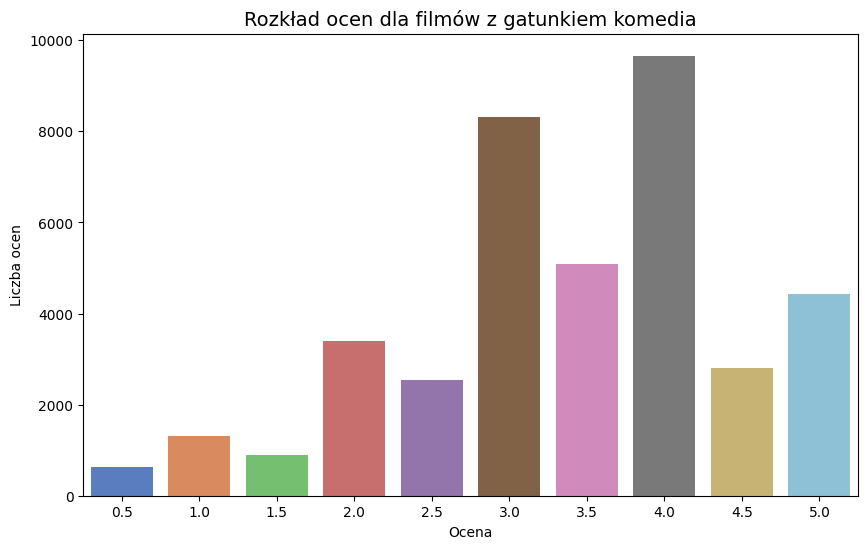

In [38]:
comedy_ratings = movie_ratings[movie_ratings['genres'].str.contains('Comedy')]
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=comedy_ratings, palette='muted')
plt.title('Rozkład ocen dla filmów z gatunkiem komedia', fontsize=14)
plt.xlabel('Ocena')
plt.ylabel('Liczba ocen')
plt.show()


- Średnia ocen wszystkich filmów akcji oraz 3 najwyżej oceniane filmy akcji:

In [39]:
action_ratings = movie_ratings[movie_ratings['genres'].str.contains('Action')]
mean_action_rating = action_ratings['rating'].mean()
print(f"Średnia ocen dla filmów z gatunkiem akcja: {mean_action_rating:.2f}")

top_action_movies = action_ratings.groupby('title')['rating'].mean().nlargest(3)
print("\nTop 3 najwyżej oceniane filmy z gatunkiem akcja:")
print(top_action_movies)


Średnia ocen dla filmów z gatunkiem akcja: 3.45

Top 3 najwyżej oceniane filmy z gatunkiem akcja:
title
Alien Contamination (1980)                                         5.0
Assignment, The (1997)                                             5.0
Battle Royale 2: Requiem (Batoru rowaiaru II: Chinkonka) (2003)    5.0
Name: rating, dtype: float64


2. System rekomendacyjny:

- SVD:

In [54]:
from surprise.model_selection import GridSearchCV
from surprise import SVD, KNNWithMeans
from surprise import Dataset
from surprise import Reader

In [55]:
reader = Reader(rating_scale=(ratings['rating'].min(), ratings['rating'].max()))

data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

svd = SVD()

param_grid = {'n_factors': [20, 50, 100], 'n_epochs': [10, 20, 30]}
gs_svd = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5)

gs_svd.fit(data)

best_svd_model = gs_svd.best_estimator['rmse']

print(f"Najlepszy wynik RMSE dla modelu SVD: {gs_svd.best_score['rmse']:.4f}")
print(f"Najlepsze parametry dla modelu SVD: {gs_svd.best_params['rmse']}")



Najlepszy wynik RMSE dla modelu SVD: 0.8678
Najlepsze parametry dla modelu SVD: {'n_factors': 20, 'n_epochs': 30}


- kNN with Means:

In [76]:
knn_with_means = KNNWithMeans(sim_options={'name': 'pearson', 'user_based': True})

param_grid_knn = {'k': [2, 3, 4, 5, 6]}

gs_knn = GridSearchCV(KNNWithMeans, param_grid_knn, measures=['rmse', 'mae'], cv=5)

gs_knn.fit(data)

best_knn_model = gs_knn.best_estimator['rmse']

print(f"Najlepszy wynik RMSE dla modelu kNN with Means: {gs_knn.best_score['rmse']:.4f}")
print(f"Najlepsze parametry dla modelu kNN with Means: {gs_knn.best_params['rmse']}")

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

- Czym różni się algorytm kNN with means od standardowego kNN?

Algorytm kNN with means różni się od standardowego kNN poprzez uwzględnienie średnich ocen użytkowników i filmów. W standardowym kNN rekomendacje opierają się wyłącznie na podobieństwie ocen użytkowników. Natomiast kNN with means uwzględnia również oceny średnie, zarówno użytkowników, jak i filmów, podczas tworzenia rekomendacji. To pozwala na lepsze radzenie sobie z rzadkimi danymi i zapewnia bardziej spersonalizowane rekomendacje. Algorytm ten stosuje wygładzanie, co pomaga w sytuacjach, gdy dane są nierównomiernie rozłożone. Poprzez uwzględnienie średnich ocen, kNN with means może bardziej wiarygodnie prognozować oceny filmów dla użytkowników. Jego celem jest zapewnienie bardziej trafnych rekomendacji poprzez uwzględnienie większej ilości informacji o preferencjach użytkowników i cechach filmów. W rezultacie kNN with means może dostarczać lepsze rekomendacje, szczególnie w przypadku, gdy dane są rzadkie lub występuje duża zróżnicowana liczba ocen między użytkownikami i filmami.

3. Rekomendacje po obejrzeniu filmu:

- Jumanji:

In [88]:
print(movies[movies['title'].str.contains('Jumanji')])

      movieId                                  title  \
1           2                         Jumanji (1995)   
9636   179401  Jumanji: Welcome to the Jungle (2017)   

                          genres  
1     Adventure|Children|Fantasy  
9636   Action|Adventure|Children  


In [89]:
movie_id_jumanji = movies[movies['title'] == 'Jumanji (1995)']['movieId'].iloc[0]
similar_movies_jumanji = knn_with_means.get_neighbors(movie_id_jumanji, k=5)

print("Rekomendowane filmy po obejrzeniu 'Jumanji':")
for movie_id in similar_movies_jumanji:
    if movie_id in movies['movieId'].values:
        print(movies[movies['movieId'] == movie_id]['title'].iloc[0])
    else:
        print(f"Film o identyfikatorze {movie_id} nie istnieje w zbiorze danych.")



Rekomendowane filmy po obejrzeniu 'Jumanji':
Beautiful Girls (1996)
Film o identyfikatorze 182 nie istnieje w zbiorze danych.
Film o identyfikatorze 90 nie istnieje w zbiorze danych.
It Could Happen to You (1994)
Ruby in Paradise (1993)


- Flint:

In [90]:
print(movies[movies['title'].str.contains('Flint')])


      movieId                                       title  \
313       355                     Flintstones, The (1994)   
2662     3564  Flintstones in Viva Rock Vegas, The (2000)   
3909     5493                        In Like Flint (1967)   
3910     5497                        Our Man Flint (1965)   
8717   126088        A Flintstones Christmas Carol (1994)   
9739   193585                                Flint (2017)   

                         genres  
313     Children|Comedy|Fantasy  
2662            Children|Comedy  
3909    Action|Adventure|Comedy  
3910    Adventure|Comedy|Sci-Fi  
8717  Animation|Children|Comedy  
9739                      Drama  


In [87]:
flint_movies = movies[movies['title'].str.contains('Flint')]
if len(flint_movies) == 0:
    print("Film 'Flint (2017)' nie został znaleziony.")
else:
    flint_movie_id = flint_movies['movieId'].values[0]
    if flint_movie_id in movie_mapper:
        similar_movies_flint = find_similar_movies(flint_movie_id, X, k=5, movie_mapper=movie_mapper, movie_inv_mapper=movie_inv_mapper)

        if len(similar_movies_flint) > 0:
            print("Rekomendowane filmy po obejrzeniu 'Flint (2017)':")
            for movie_id in similar_movies_flint:
                print(movies[movies['movieId'] == movie_id]['title'].iloc[0])
        else:
            print("Nie znaleziono rekomendacji dla filmu 'Flint (2017)'.")
    else:
        print("Film 'Flint (2017)' nie został znaleziony w zestawie danych ocen.")


Rekomendowane filmy po obejrzeniu 'Flint (2017)':
Birdcage, The (1996)
Operation Dumbo Drop (1995)
Sgt. Bilko (1996)
Arrival, The (1996)
Richard III (1995)
